Raw metric data from Prometheus:
[{'metric': {'pod_name': 'chain-shipments-data-chain-9xp2m-system-dag-driver-3393739779'}, 'value': [1742146082.1, '1.701']}, {'metric': {'pod_name': 'chain-shipments-data-chain-9xp2m-system-container-driver-1086088883'}, 'value': [1742146082.1, '2.283']}, {'metric': {'pod_name': 'chain-shipments-data-chain-9xp2m-system-container-impl-2974586005'}, 'value': [1742146082.1, '1.545']}, {'metric': {'pod_name': 'chain-shipments-data-chain-9xp2m-system-container-driver-92058162'}, 'value': [1742146082.1, '1.962']}, {'metric': {'pod_name': 'chain-shipments-data-chain-9xp2m-system-container-impl-2996506972'}, 'value': [1742146082.1, '2.265']}, {'metric': {'pod_name': 'chain-shipments-data-chain-9xp2m-system-container-impl-1620947167'}, 'value': [1742146082.1, '0.546']}, {'metric': {'pod_name': 'chain-shipments-data-chain-9xp2m-system-container-driver-2767975441'}, 'value': [1742146082.1, '0.717']}]

DataFrame before cleaning:
                                   

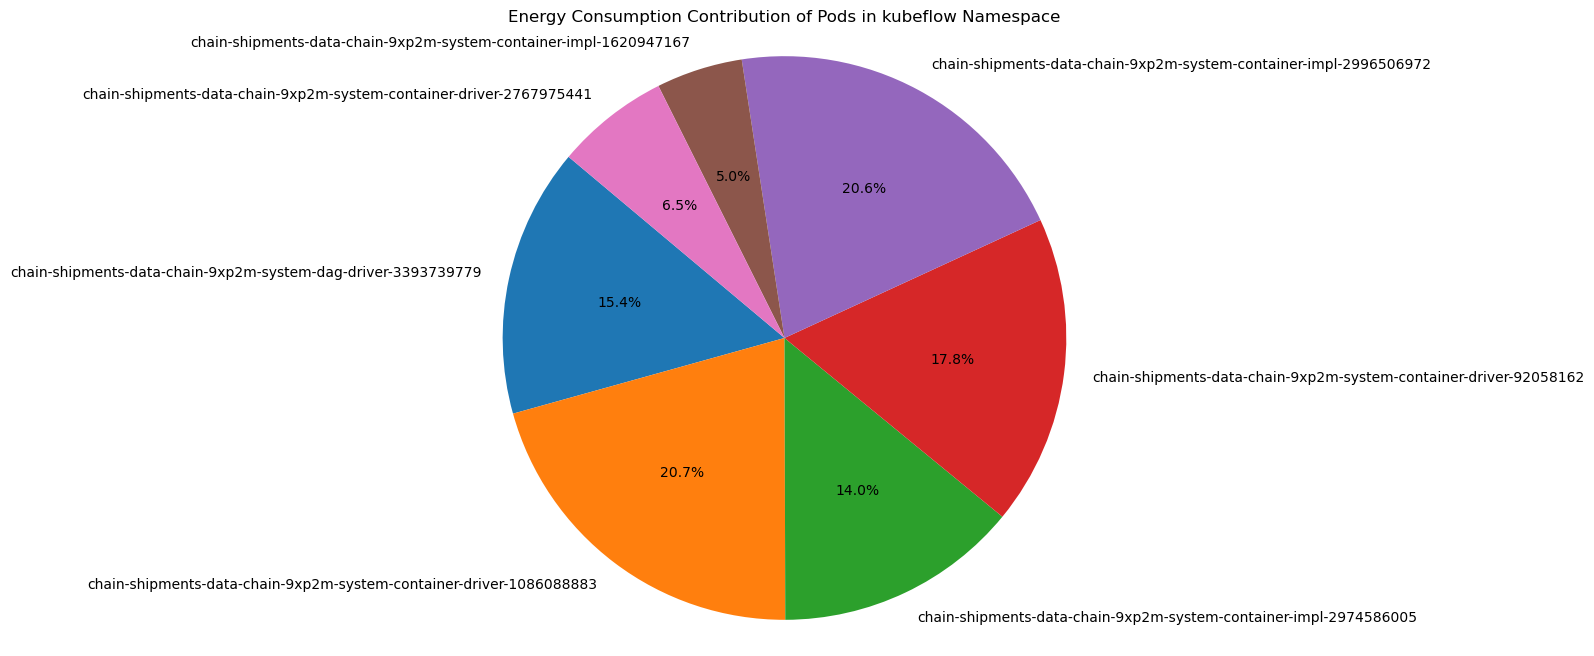

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from prometheus_api_client import PrometheusConnect
import numpy as np

# Connect to Prometheus
prometheus_url = "http://localhost:9090"  # Replace with your Prometheus server URL
prom = PrometheusConnect(url=prometheus_url, disable_ssl=True)

# Define the Prometheus query
 #'sum(rate(kepler_container_core_joules_total{container_namespace="kubeflow"}[5m])) by (pod_name)'
#query = 'sum(kepler_container_core_joules_total{container_namespace=~"kubeflow"}) by (pod_name)'  ## GOOD !! 
query = 'sum(kepler_container_core_joules_total{container_namespace=~"kubeflow", pod_name=~".*shipments-data-chain.*"}) by (pod_name)'

# Fetch data from Prometheus
metric_data = prom.custom_query(query)

# Debug: Print the raw metric data
print("Raw metric data from Prometheus:")
print(metric_data)

# Process the data into a pandas DataFrame
data = []
for metric in metric_data:
    pod_name = metric['metric']['pod_name']
    energy_value = metric['value'][1]  # Extract the energy value (as string)
    
    # Convert energy_value to float, handling invalid cases
    try:
        energy_value = float(energy_value)
    except (ValueError, TypeError):
        print(f"Warning: Invalid energy value for pod {pod_name}: {energy_value}. Skipping this pod.")
        continue  # Skip this pod if the energy value is invalid
    
    data.append({'Pod': pod_name, 'Energy': energy_value})

# Create DataFrame
df = pd.DataFrame(data)

# Debug: Print the DataFrame before cleaning
print("\nDataFrame before cleaning:")
print(df)

# Check for NaN or infinite values and clean the data
df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinite values with NaN
df.dropna(subset=['Energy'], inplace=True)  # Drop rows with NaN values in the 'Energy' column

# Debug: Print the DataFrame after cleaning
print("\nDataFrame after cleaning:")
print(df)

# Check if the DataFrame is empty after cleaning
if df.empty:
    raise ValueError("No valid data available to plot. Check your Prometheus query and data.")

# Ensure all energy values are finite and greater than or equal to 0
if not (df['Energy'] >= 0).all():
    raise ValueError("Energy values must be non-negative.")

# Calculate the total energy consumption
total_energy = df['Energy'].sum()

# Calculate the percentage contribution of each pod
df['Contribution (%)'] = (df['Energy'] / total_energy) * 100

# Debug: Print the final DataFrame
print("\nFinal DataFrame for plotting:")
print(df)

# Plotting
plt.figure(figsize=(8, 8))
plt.pie(df['Contribution (%)'], labels=df['Pod'], autopct='%1.1f%%', startangle=140)
plt.title('Energy Consumption Contribution of Pods in kubeflow Namespace')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the plot
plt.show()

Raw metric data from Prometheus:
[{'metric': {'pod_name': 'chain-shipments-data-chain-9xp2m-system-dag-driver-3393739779'}, 'value': [1742143083.651, '1.701']}, {'metric': {'pod_name': 'chain-shipments-data-chain-9xp2m-system-container-driver-1086088883'}, 'value': [1742143083.651, '2.283']}, {'metric': {'pod_name': 'chain-shipments-data-chain-9xp2m-system-container-impl-2974586005'}, 'value': [1742143083.651, '1.545']}, {'metric': {'pod_name': 'chain-shipments-data-chain-9xp2m-system-container-driver-92058162'}, 'value': [1742143083.651, '1.962']}, {'metric': {'pod_name': 'chain-shipments-data-chain-9xp2m-system-container-impl-2996506972'}, 'value': [1742143083.651, '2.265']}, {'metric': {'pod_name': 'chain-shipments-data-chain-9xp2m-system-container-impl-1620947167'}, 'value': [1742143083.651, '0.546']}, {'metric': {'pod_name': 'chain-shipments-data-chain-9xp2m-system-container-driver-2767975441'}, 'value': [1742143083.651, '0.717']}]

DataFrame before cleaning:
                     

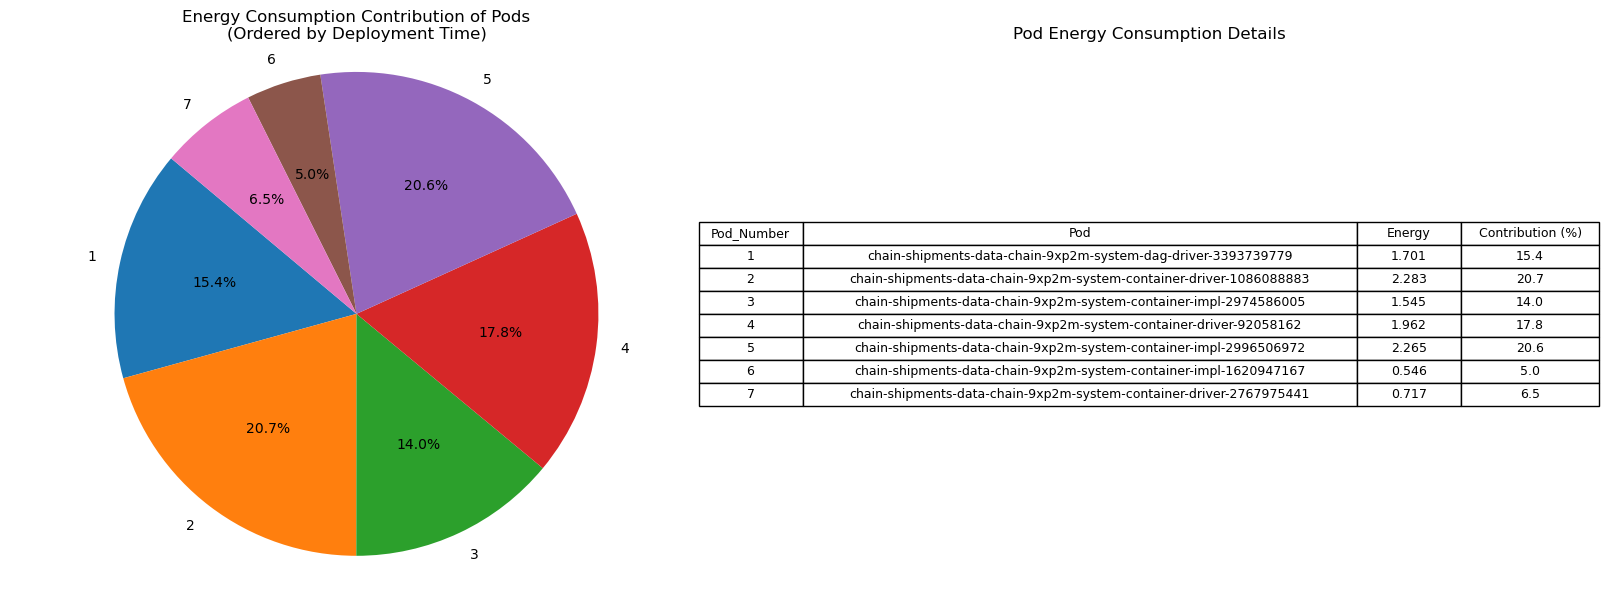

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from prometheus_api_client import PrometheusConnect
import numpy as np
from datetime import datetime

# Connect to Prometheus
prometheus_url = "http://localhost:9090"  # Replace with your Prometheus server URL
prom = PrometheusConnect(url=prometheus_url, disable_ssl=True)

# Define the Prometheus query
query = 'sum(kepler_container_core_joules_total{container_namespace=~"kubeflow", pod_name=~".*shipments-data-chain.*"}) by (pod_name)'

# Fetch data from Prometheus
metric_data = prom.custom_query(query)

# Debug: Print the raw metric data
print("Raw metric data from Prometheus:")
print(metric_data)

# Process the data into a pandas DataFrame
data = []
for metric in metric_data:
    pod_name = metric['metric']['pod_name']
    energy_value = metric['value'][1]  # Extract the energy value (as string)
    timestamp = metric['value'][0]  # Extract the timestamp (as Unix epoch time)
    
    # Convert energy_value to float, handling invalid cases
    try:
        energy_value = float(energy_value)
    except (ValueError, TypeError):
        print(f"Warning: Invalid energy value for pod {pod_name}: {energy_value}. Skipping this pod.")
        continue  # Skip this pod if the energy value is invalid
    
    data.append({
        'Pod': pod_name,
        'Energy': energy_value,
        'Timestamp': float(timestamp)  # Keep the timestamp as a float for sorting
    })

# Create DataFrame
df = pd.DataFrame(data)

# Debug: Print the DataFrame before cleaning
print("\nDataFrame before cleaning:")
print(df)

# Check for NaN or infinite values and clean the data
df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinite values with NaN
df.dropna(subset=['Energy'], inplace=True)  # Drop rows with NaN values in the 'Energy' column

# Debug: Print the DataFrame after cleaning
print("\nDataFrame after cleaning:")
print(df)

# Check if the DataFrame is empty after cleaning
if df.empty:
    raise ValueError("No valid data available to plot. Check your Prometheus query and data.")

# Ensure all energy values are finite and greater than or equal to 0
if not (df['Energy'] >= 0).all():
    raise ValueError("Energy values must be non-negative.")

# Sort the DataFrame by timestamp to determine the order of deployment
df = df.sort_values(by='Timestamp', ascending=True).reset_index(drop=True)

# Assign a number to each pod based on its position in the sorted DataFrame
df['Pod_Number'] = df.index + 1  # Start numbering from 1

# Calculate the total energy consumption
total_energy = df['Energy'].sum()

# Calculate the percentage contribution of each pod
df['Contribution (%)'] = (df['Energy'] / total_energy) * 100

# Round the percentage contribution to one decimal place
df['Contribution (%)'] = df['Contribution (%)'].round(1)

# Debug: Print the final DataFrame
print("\nFinal DataFrame for plotting:")
print(df)

# Plotting
plt.figure(figsize=(16, 6))  # Increase figure width for better table layout

# Create a subplot for the pie chart
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.pie(df['Contribution (%)'], labels=df['Pod_Number'], autopct='%1.1f%%', startangle=140)
plt.title('Energy Consumption Contribution of Pods\n(Ordered by Deployment Time)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Create a subplot for the table
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.axis('off')  # Hide axes for the table

# Prepare data for the table (exclude Timestamp_Readable)
table_data = df[['Pod_Number', 'Pod', 'Energy', 'Contribution (%)']].values

# Wrap long pod names into multiple lines
# max_line_length = 20  # Maximum characters per line
# for i, pod_name in enumerate(df['Pod']):
#     wrapped_pod_name = '\n'.join([pod_name[j:j+max_line_length] for j in range(0, len(pod_name), max_line_length)])
#     table_data[i, 1] = wrapped_pod_name

# Create the table
table = plt.table(
    cellText=table_data,
    colLabels=['Pod_Number', 'Pod', 'Energy', 'Contribution (%)'],
    cellLoc='center',
    loc='center'
)

# Adjust table properties
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.2)  # Scale the table for better readability

# Dynamically adjust column widths based on content
column_widths = [0.15, 0.6, 0.15, 0.2]  # Default widths
max_pod_name_length = max(len(pod_name) for pod_name in df['Pod'])  # Find the longest pod name
column_widths[1] = min(0.8, 0.1 + 0.02 * max_pod_name_length)  # Adjust Pod column width dynamically

for i, width in enumerate(column_widths):
    for j in range(len(table_data) + 1):  # +1 to include the header row
        table[(j, i)].set_width(width)

# Wrap text in cells
for key, cell in table.get_celld().items():
    cell.set_text_props(wrap=True)

plt.title('Pod Energy Consumption Details')

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot and table as an image
plt.savefig('energy_consumption_plot_and_table.png', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()

Processing pipeline chain: shipments_anonymize_chain
Raw metric data from Prometheus:
[{'metric': {'pod_name': 'chain-shipments-anonymize-chain-7szdw-system-dag-driver-2619743256'}, 'value': [1742146930.669, '2.598']}, {'metric': {'pod_name': 'chain-shipments-anonymize-chain-7szdw-system-container-impl-2213950074'}, 'value': [1742146930.669, '2.973']}, {'metric': {'pod_name': 'chain-shipments-anonymize-chain-7szdw-system-container-driver-2837884372'}, 'value': [1742146930.669, '0']}, {'metric': {'pod_name': 'chain-shipments-anonymize-chain-7szdw-system-container-impl-2142835376'}, 'value': [1742146930.669, '1.746']}, {'metric': {'pod_name': 'chain-shipments-anonymize-chain-7szdw-system-container-driver-1276174054'}, 'value': [1742146930.669, '1.569']}, {'metric': {'pod_name': 'chain-shipments-anonymize-chain-7szdw-system-container-driver-2159087137'}, 'value': [1742146930.669, '2.055']}, {'metric': {'pod_name': 'chain-shipments-anonymize-chain-7szdw-system-container-impl-2421153807'}, 

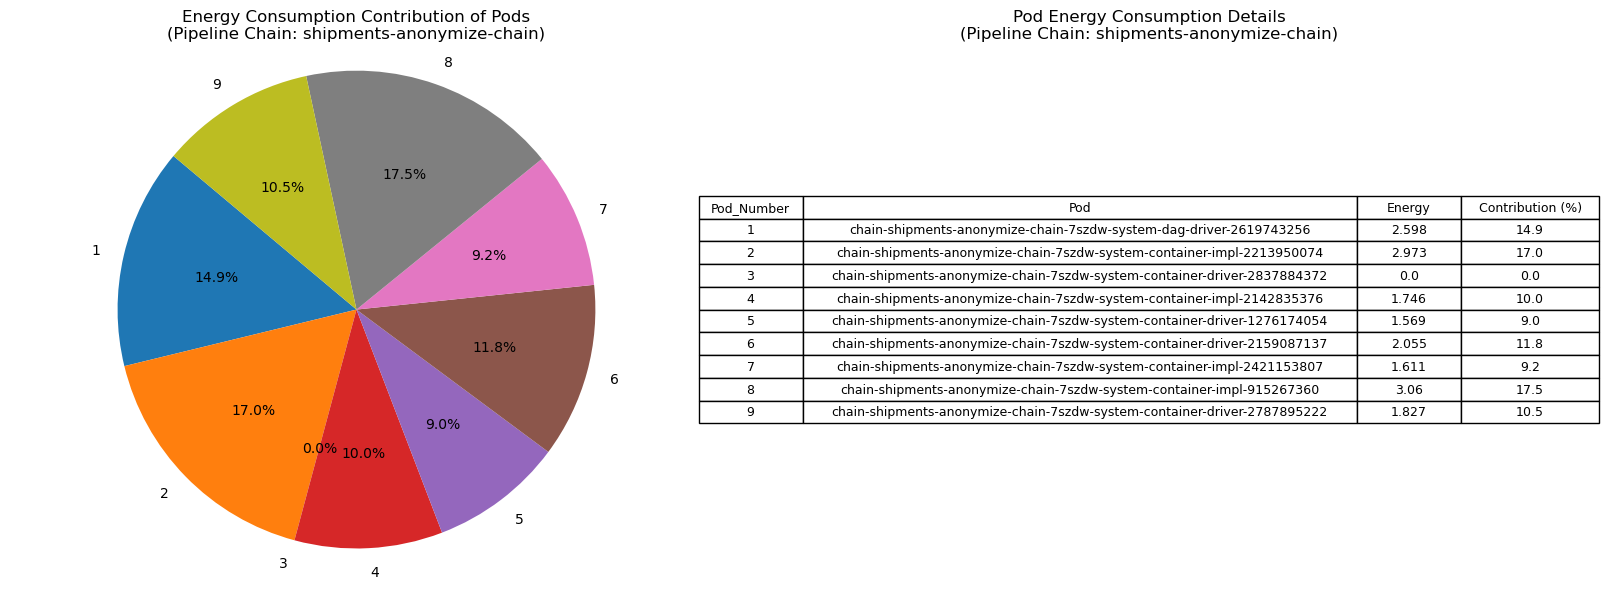

Processing pipeline chain: shipments_data_chain
Raw metric data from Prometheus:
[{'metric': {'pod_name': 'chain-shipments-data-chain-9xp2m-system-dag-driver-3393739779'}, 'value': [1742146931.14, '1.701']}, {'metric': {'pod_name': 'chain-shipments-data-chain-9xp2m-system-container-driver-1086088883'}, 'value': [1742146931.14, '2.283']}, {'metric': {'pod_name': 'chain-shipments-data-chain-9xp2m-system-container-impl-2974586005'}, 'value': [1742146931.14, '1.545']}, {'metric': {'pod_name': 'chain-shipments-data-chain-9xp2m-system-container-driver-92058162'}, 'value': [1742146931.14, '1.962']}, {'metric': {'pod_name': 'chain-shipments-data-chain-9xp2m-system-container-impl-2996506972'}, 'value': [1742146931.14, '2.265']}, {'metric': {'pod_name': 'chain-shipments-data-chain-9xp2m-system-container-impl-1620947167'}, 'value': [1742146931.14, '0.546']}, {'metric': {'pod_name': 'chain-shipments-data-chain-9xp2m-system-container-driver-2767975441'}, 'value': [1742146931.14, '0.717']}]

DataFra

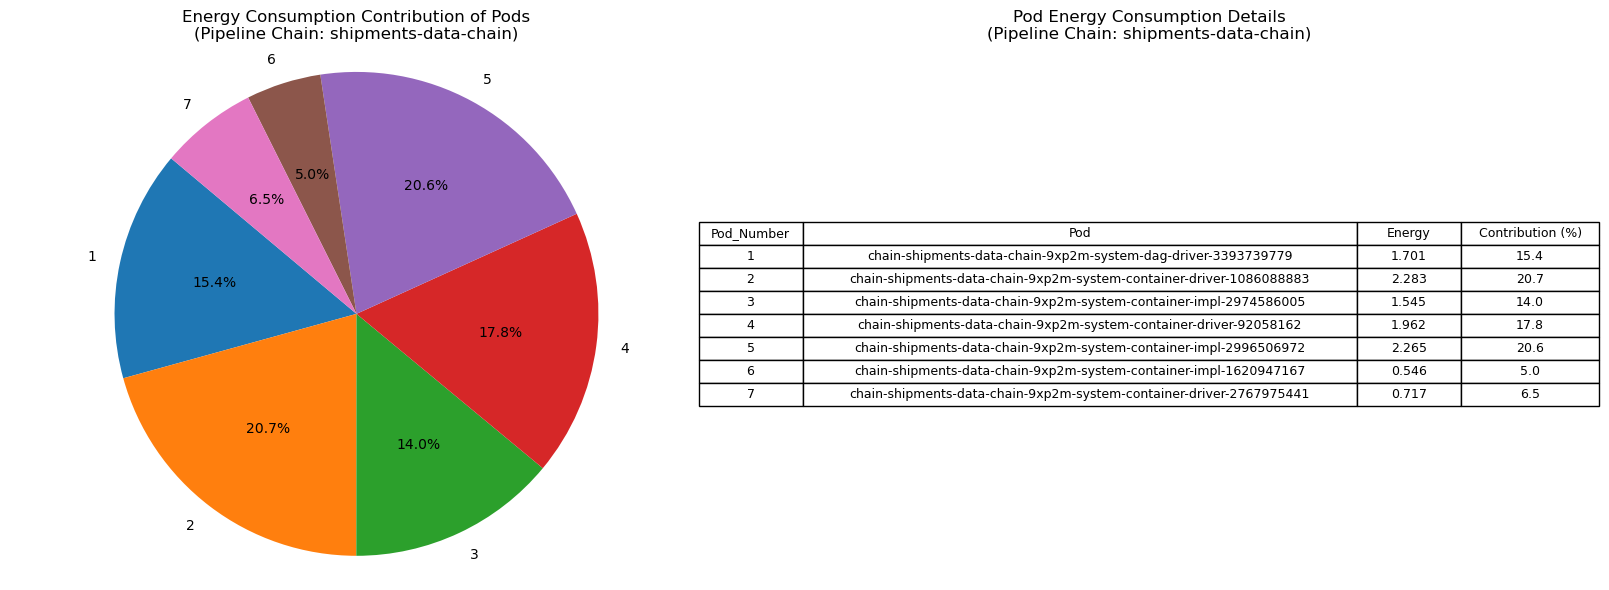

In [48]:
# Drawing the plots, the number assign to the pods for every pipeline is based on the time of deployment which would help to know which pod is related to which stage.

import pandas as pd
import matplotlib.pyplot as plt
from prometheus_api_client import PrometheusConnect
import numpy as np
from datetime import datetime
import yaml

def draw_plot(pipeline_chain_name_input:str):

    prometheus_url = "http://localhost:9090"  # Replace with your Prometheus server URL
    prom = PrometheusConnect(url=prometheus_url, disable_ssl=True)
    pipeline_chain_name = pipeline_chain_name_input.replace('_','-')
    # Define the Prometheus query
    query = f'sum(kepler_container_core_joules_total{{container_namespace=~"kubeflow", pod_name=~".*{pipeline_chain_name}.*"}}) by (pod_name)'
    
    # Fetch data from Prometheus
    metric_data = prom.custom_query(query)
    
    # Debug: Print the raw metric data
    print("Raw metric data from Prometheus:")
    print(metric_data)
    
    # Process the data into a pandas DataFrame
    data = []
    for metric in metric_data:
        pod_name = metric['metric']['pod_name']
        energy_value = metric['value'][1]  # Extract the energy value (as string)
        timestamp = metric['value'][0]  # Extract the timestamp (as Unix epoch time)
        
        # Convert energy_value to float, handling invalid cases
        try:
            energy_value = float(energy_value)
        except (ValueError, TypeError):
            print(f"Warning: Invalid energy value for pod {pod_name}: {energy_value}. Skipping this pod.")
            continue  # Skip this pod if the energy value is invalid
        
        data.append({
            'Pod': pod_name,
            'Energy': energy_value,
            'Timestamp': float(timestamp)  # Keep the timestamp as a float for sorting
        })
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Debug: Print the DataFrame before cleaning
    print("\nDataFrame before cleaning:")
    print(df)
    
    # Check for NaN or infinite values and clean the data
    df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinite values with NaN
    df.dropna(subset=['Energy'], inplace=True)  # Drop rows with NaN values in the 'Energy' column
    
    # Debug: Print the DataFrame after cleaning
    print("\nDataFrame after cleaning:")
    print(df)
    
    # Check if the DataFrame is empty after cleaning
    if df.empty:
        raise ValueError("No valid data available to plot. Check your Prometheus query and data.")
    
    # Ensure all energy values are finite and greater than or equal to 0
    if not (df['Energy'] >= 0).all():
        raise ValueError("Energy values must be non-negative.")
    
    # Sort the DataFrame by timestamp to determine the order of deployment
    df = df.sort_values(by='Timestamp', ascending=True).reset_index(drop=True)
    
    # Assign a number to each pod based on its position in the sorted DataFrame
    df['Pod_Number'] = df.index + 1  # Start numbering from 1
    
    # Calculate the total energy consumption
    total_energy = df['Energy'].sum()
    
    # Calculate the percentage contribution of each pod
    df['Contribution (%)'] = (df['Energy'] / total_energy) * 100
    
    # Round the percentage contribution to one decimal place
    df['Contribution (%)'] = df['Contribution (%)'].round(1)
    
    # Debug: Print the final DataFrame
    print("\nFinal DataFrame for plotting:")
    print(df)
    
    # Plotting
    plt.figure(figsize=(16, 6))  # Increase figure width for better table layout
    
    # Create a subplot for the pie chart
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
    plt.pie(df['Contribution (%)'], labels=df['Pod_Number'], autopct='%1.1f%%', startangle=140)
    plt.title(f'Energy Consumption Contribution of Pods\n(Pipeline Chain: {pipeline_chain_name})')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    # Create a subplot for the table
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
    plt.axis('off')  # Hide axes for the table
    
    # Prepare data for the table (exclude Timestamp_Readable)
    table_data = df[['Pod_Number', 'Pod', 'Energy', 'Contribution (%)']].values
    
    # Wrap long pod names into multiple lines
    # max_line_length = 20  # Maximum characters per line
    # for i, pod_name in enumerate(df['Pod']):
    #     wrapped_pod_name = '\n'.join([pod_name[j:j+max_line_length] for j in range(0, len(pod_name), max_line_length)])
    #     table_data[i, 1] = wrapped_pod_name
    
    # Create the table
    table = plt.table(
        cellText=table_data,
        colLabels=['Pod_Number', 'Pod', 'Energy', 'Contribution (%)'],
        cellLoc='center',
        loc='center'
    )
    
    # Adjust table properties
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.2)  # Scale the table for better readability
    
    # Dynamically adjust column widths based on content
    column_widths = [0.15, 0.6, 0.15, 0.2]  # Default widths
    max_pod_name_length = max(len(pod_name) for pod_name in df['Pod'])  # Find the longest pod name
    column_widths[1] = min(0.8, 0.1 + 0.02 * max_pod_name_length)  # Adjust Pod column width dynamically
    
    for i, width in enumerate(column_widths):
        for j in range(len(table_data) + 1):  # +1 to include the header row
            table[(j, i)].set_width(width)
    
    # Wrap text in cells
    for key, cell in table.get_celld().items():
        cell.set_text_props(wrap=True)
    
    plt.title(f'Pod Energy Consumption Details\n(Pipeline Chain: {pipeline_chain_name})')
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Save the plot and table as an image
    plt.savefig(f'energy_consumption_{pipeline_chain_name}.png', bbox_inches='tight', dpi=300)
    
    # Show the plot
    plt.show()
    
with open('./data/shipments_pipeline_config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Extract deployment and pipeline chain information
namespace = config['Deployment']['namespace']
prometheus_url = config['Deployment']['prometheusURL']
pipeline_chains = config['pipelineChains']

# Iterate over each pipeline chain and call draw_plot
for chain in pipeline_chains:
    pipeline_chain_name = chain['name']
    print(f"Processing pipeline chain: {pipeline_chain_name}")
    draw_plot(pipeline_chain_name)